In [ ]:
!pip install --upgrade keras tensorflow

In [337]:
import os

from PIL import Image, ImageOps
import numpy as np

import tensorflow as tf

from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, Dense, BatchNormalization, LeakyReLU, Lambda

In [559]:
def gray_filter(X, new_bg):
    bg = X[0, 0, :]
    X_hat = X[7:45, 10:84, :]
    pix_max, pix_med, pix_min = X_hat.max(axis=2), np.median(X_hat, axis=2), X_hat.min(axis=2)

    mask = (pix_med * 1.5 <= pix_max) | (pix_min * 1.5 <= pix_med) | ((pix_min+pix_med+pix_max > 175/255 * 3) & (abs(pix_min+pix_med+pix_max - bg.sum()) > 1))

    X_hat[mask] = [25/255, 22/255, 41/255]
    X[7:45, 10:84, :] = X_hat
    
    bg_pixels = np.abs(X - bg).sum(axis=2) < .08
    X[bg_pixels] = new_bg
    return X

In [ ]:
# load pics
X = np.zeros((len(os.listdir('pics')), 432, 288, 1,))
for i, path in enumerate(os.listdir('pics')):
    if path[0] == '.':
        continue
    img = Image.open('pics/' + path)
    X[i] = np.array(ImageOps.grayscale(img)).reshape(451, 300, 1)[8:440, 8:296, :] / 255
    

In [561]:
new_bg = X[1, 0, 0, :]

# load pics (color)
out_size = (128, 96)
X = np.zeros((len(os.listdir('pics')), *out_size, 3))
for i, path in enumerate(os.listdir('pics')):
    if path[0] == '.':
        continue
    img = Image.open('pics/' + path).resize(out_size[::-1])
    X[i] = np.array(img) / 255
    X[i] = gray_filter(X[i], new_bg)
#     img2 = Image.fromarray((255 * X[i]).reshape(128, 96, 3).astype(np.uint8))
    

In [562]:
X.shape

(1277, 128, 96, 3)

In [563]:
train_mask = np.zeros(len(X))
train_mask[:int(len(X) * 0.8)] = 1
np.random.shuffle(train_mask)
X_train = X[train_mask == 1]
X_test = X[train_mask == 0]

In [564]:
np.save('datasets/train_128_color_bgfilt', X_train)
np.save('datasets/test_128_color_bgfilt', X_test)

In [348]:
np.save('datasets/train_440', X_train)
np.save('datasets/test_440', X_test)

In [315]:
def model1():
    model = models.Sequential()

    # encode
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(432, 288, 1)))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    # 54 x 36 x 16 features (1 / 4 representation)                                   # TODO train this

    # decode
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

    model.compile(optimizer='adam', loss='binary_crossentropy')

    model.summary()
    return model

In [316]:
model1 = model1()
# model2 = model2()

model1.fit(X_train[:100], X_train[:100], epochs=40, batch_size=8) # 
# model2.fit(X_train[:100], X_train[:100], epochs=40, batch_size=8)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_208 (Conv2D)          (None, 432, 288, 64)      640       
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 216, 144, 64)      0         
_________________________________________________________________
conv2d_209 (Conv2D)          (None, 216, 144, 32)      18464     
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 108, 72, 32)       0         
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 108, 72, 16)       4624      
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 54, 36, 16)        0         
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 54, 36, 16)      

In [317]:
train_preds1 = model1.predict(X_train[:8])
test_preds1 = model1.predict(X_test[:100])

# train_preds2 = model2.predict(X_train[:8])
# test_preds2 = model2.predict(X_test[:100])

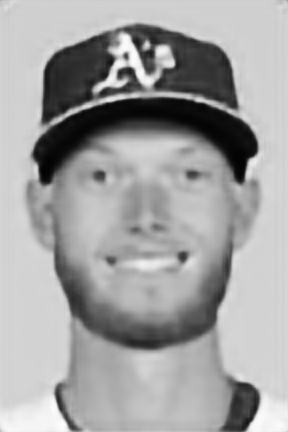

In [318]:
Image.fromarray((255 * test_preds1[0, :, :, 0]).astype(np.uint8))

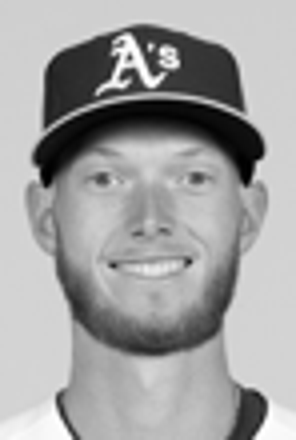

In [319]:
Image.fromarray((255 * X_test[0, :, :, 0]).astype(np.uint8)).resize((296//4, 440//4)).resize((296, 440))

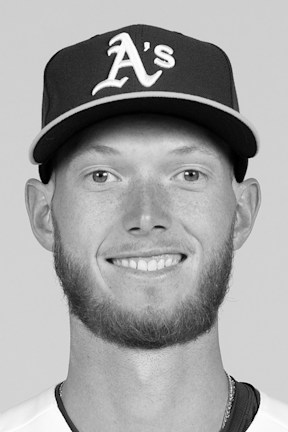

In [350]:
Image.fromarray((255 * X_test[0, :, :, 0]).astype(np.uint8))

In [ ]:
Image.fromarray((255 * train_preds2[0, :, :, 0]).astype(np.uint8))

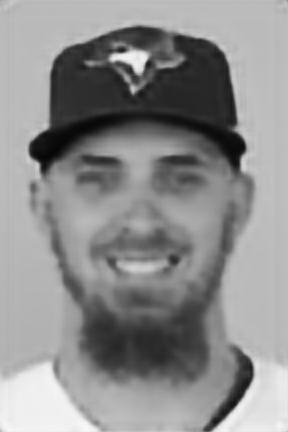

In [320]:
Image.fromarray((255 * train_preds1[0, :, :, 0]).astype(np.uint8))

In [ ]:
Image.fromarray((255 * train_preds2[0, :, :, 0]).astype(np.uint8))

In [288]:
shohei_sample = np.array([np.array(shohei_img)[6:-13, 6:-6].reshape(432, 288, 1)])
shohei_sample.shape

(1, 432, 288, 1)

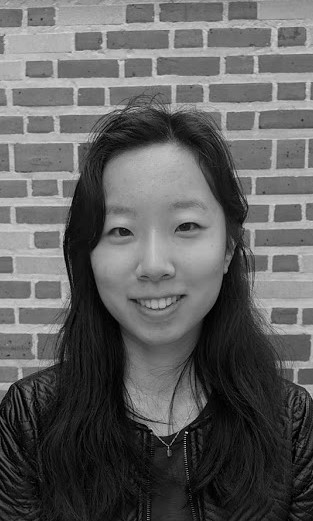

In [321]:
annabel_img = ImageOps.grayscale(Image.open('pics/annabel.jpg'))
annabel_img

In [322]:
annabel = np.array(annabel_img)[44:-45, 12:-13] / 255

In [323]:
annabel_sample = np.array([annabel.reshape(432, 288, 1)])
annabel_sample.shape

(1, 432, 288, 1)

In [324]:
pred = (255 * model1.predict(annabel_sample)).astype(np.uint8)[0, :, :, 0]


In [325]:
pred.mean()

96.47293756430041

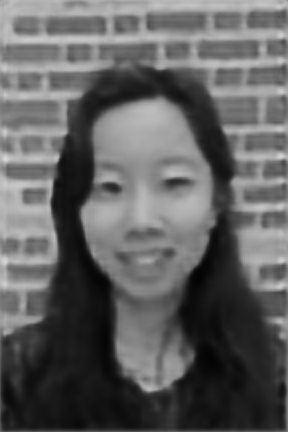

In [326]:
Image.fromarray(pred)